<a id='contents'></a>

## Contents

[Messing around with spatial clustering in Mesa/python](#messing)  
[Changing mu](#mu)  
[Changing Sigma](#sigma)  
[Making a tropical forest](#realforest)  
[Modeling deforestation](#deforest)  
* [Fragmentation of forest](#fragmentation)
* [Evenly dispersed harvesting](#evenharvest)

<a id='messing'></a>
# Messing around with spatial clustering in Mesa/python

We need our trees to have some sort of clustering coefficient, because some of my questions focus on deforestation and fragmentation. Let's try a Thomas process for generating clustering. This is adapted from Connor Johnson's [blog post](http://connor-johnson.com/2014/02/25/spatial-point-processes/) on point processes in python.

In [1]:
import pickle
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from FAmodel import Forest
from FAmodel import sumendos
from FAmodel import sumdecomps
from FAagents import Tree, Wood, Fungus
import thomasprocess as tp

%matplotlib inline

We need a basic 2-D poisson-process for creating events. Rt is our variable for the average number of events for a given square size, which is defined by the side length variable Dx. Also built-in here is a y-dimension, so this function can handle rectangles. But I don't think we'll use this option much. 

In [2]:
def PoissonPP( rt, Dx, Dy=None ):
    '''
    Determines the number of events `N` for a rectangular region,
    given the rate `rt` and the dimensions, `Dx`, `Dy`.
    Returns a <2xN> NumPy array.
    '''
    if Dy == None:
        Dy = Dx
    N = scipy.stats.poisson( rt*Dx*Dy ).rvs()
    x = scipy.stats.uniform.rvs(0,Dx,((N,1)))
    y = scipy.stats.uniform.rvs(0,Dy,((N,1)))
    P = np.hstack((x,y))
    return(P)

Try it out, visualize:

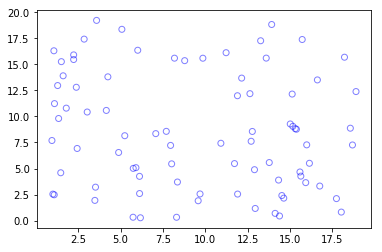

In [26]:
rate, Dx = 0.2, 20
P = PoissonPP( rate, Dx ).T
plt.scatter( P[0], P[1], edgecolor='b', facecolor='none', alpha=0.5 )
#plt.show()

Now we can use this to seed a cluster-generation process. The above poisson process will seed a landscape with "parent" points. The function below then places "child" points around these parent points. Here we'll use a Thomas process, which generates points around the parent in with a gaussian-type distribution, radially. A common alternative would be to use a matern process, but the Thomas process seems a little more intuitive to me. 

In [3]:
def ThomasPP( kappa, sigma, mu, Dx ):
    '''
    each forming a Poisson( mu ) numbered cluster of points,
    having an isotropic Gaussian distribution with variance `sigma`
    '''
    # create a set of parent points from a Poisson( kappa )
    # distribution on the square region [0,Dx] X [0,Dx]
    parents = PoissonPP( kappa, Dx )
    # M is the number of parents
    M = parents.shape[0]
    # an empty list for the Thomas process points
    TP = list()
    # for each parent point..
    for i in range( M ):
        # determine a number of children according
        # to a Poisson( mu ) distribution
        N = scipy.stats.poisson( mu ).rvs()
    # for each child point..
        for j in range( N ):
        # place a point centered on the location of the parent according
        # to an isotropic Gaussian distribution with sigma variance
                pdf = scipy.stats.norm( loc=parents[i,:2], scale=(sigma,sigma) )
                # add the child point to the list TP
                TP.append( list( pdf.rvs(2) ) )
    x,y = zip(*TP)
    pts = [x,y]
    return pts


Kappa determines the density of parent points on the landscape, +/- equivalent to the number of clusters. Mu determines the poisson rate of the secondary clusters, +/- controls number of child points. Sigma is the variance on the the spread of the child points, so this should act to concentrate (tighten up) the clusters, more events in a smaller radius. 

In [ ]:
So what happens when we vary the parameters?

In [28]:
aa = ThomasPP(kappa=3, sigma=0.2, mu=15, Dx=8)

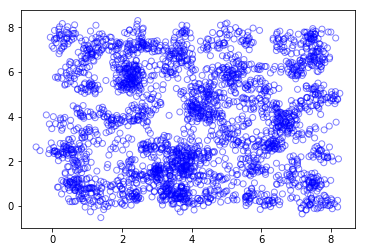

In [31]:
plt.scatter( aa[0], aa[1], edgecolor='b', facecolor='none', alpha=0.5 )

Compare this to a lowered 

In [32]:
aa = ThomasPP(kappa=3, sigma=0.1, mu=15, Dx=8)

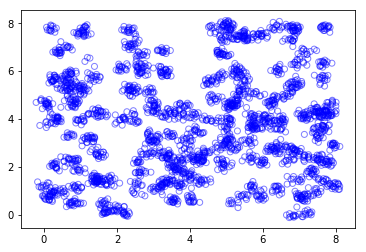

In [34]:
plt.scatter( aa[0], aa[1], edgecolor='b', facecolor='none', alpha=0.5 )

In [35]:
aa = ThomasPP(kappa=3, sigma=0.2, mu=7, Dx=8)

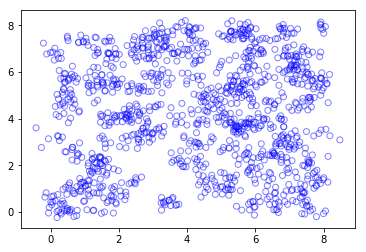

In [36]:
plt.scatter( aa[0], aa[1], edgecolor='b', facecolor='none', alpha=0.5 )

[Back to contents](#contents)

<a id='mu'></a>

### Changing mu

Let's look at mu, the rate/number of child points, keeping the parent point behavior (kappa) and child variation (mu) constant. 

In [50]:
a1 = ThomasPP(kappa=2, sigma=0.1, mu=30, Dx=10)
a2 = ThomasPP(kappa=2, sigma=0.1, mu=20, Dx=10)
a3 = ThomasPP(kappa=2, sigma=0.1, mu=10, Dx=10)

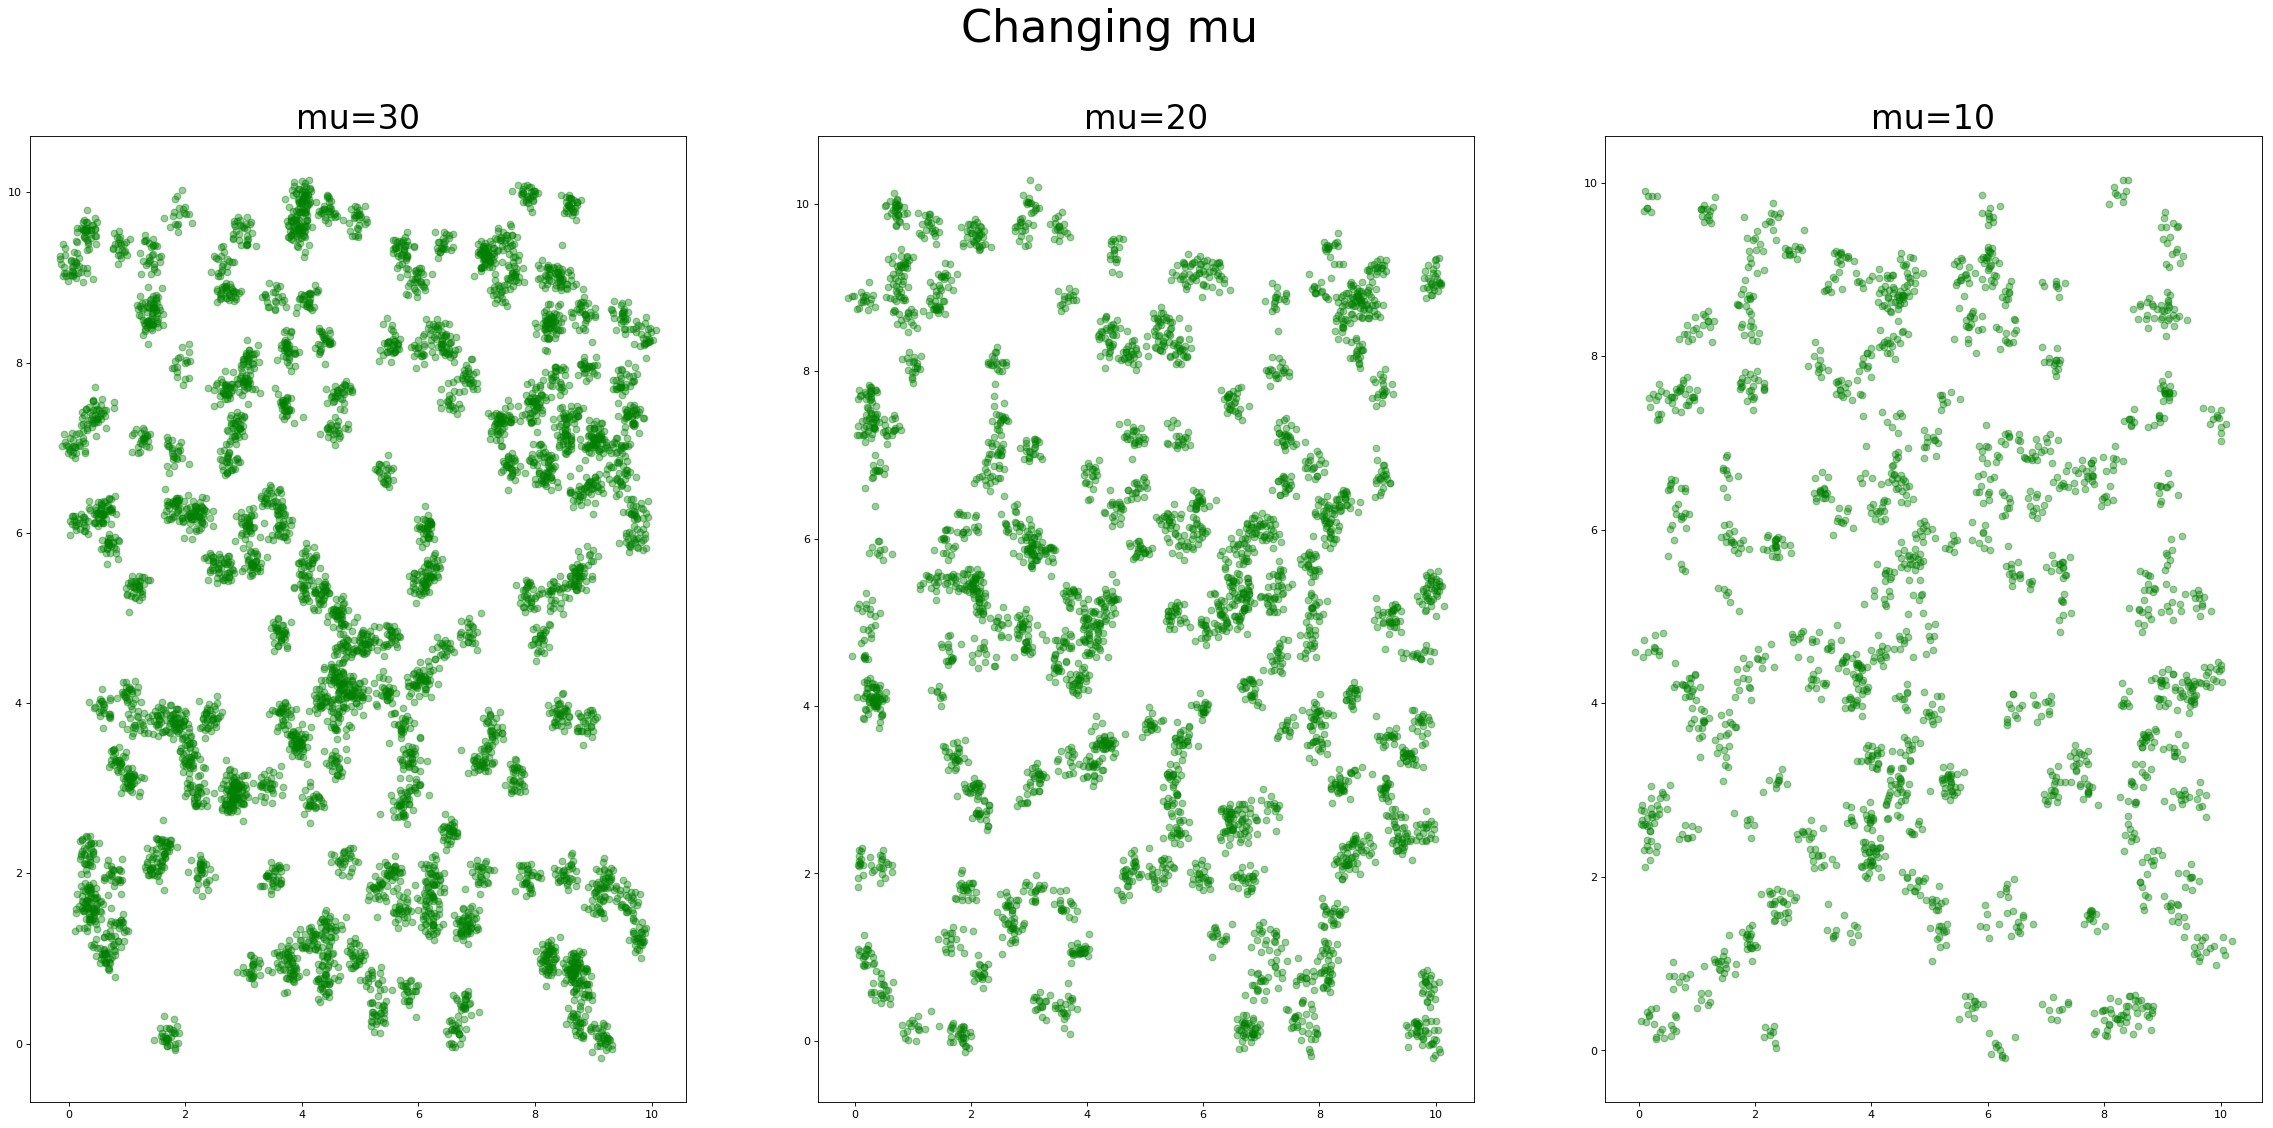

In [69]:
fig=plt.figure(figsize=(36, 16), dpi= 80, facecolor='w', edgecolor='k')
fig.suptitle("Changing mu", fontsize=40)

plt.subplot(131)
plt.title("mu=30", fontsize=30)
plt.scatter(a1[0],a1[1], c='g', alpha = 0.4) 
plt.subplot(132)
plt.title("mu=20", fontsize=30)
plt.scatter(a2[0],a2[1], c='g', alpha = 0.4)
plt.subplot(133)
plt.title("mu=10", fontsize=30)
plt.scatter(a3[0],a3[1], c='g', alpha = 0.4)

In [70]:
[len(a1[0]),
len(a2[0]),
len(a3[0])]

[5995, 3837, 1999]

Makes sense, reducing mu by a third each time reduces the number of points by ~1/3. This results in more isolated clusters, just because there are fewer trees to bridge the gaps between. 

[back to contents](#contents)

<a id='sigma'></a>

## Changing sigma

Now let's try varing sigma, the variance of the child points around their parents. 

In [30]:
b1 = tp.ThomasPP(kappa=2, sigma=0.9, mu=20, Dx=10)
b2 = tp.ThomasPP(kappa=2, sigma=0.5, mu=20, Dx=10)
b3 = tp.ThomasPP(kappa=2, sigma=0.1, mu=20, Dx=10)

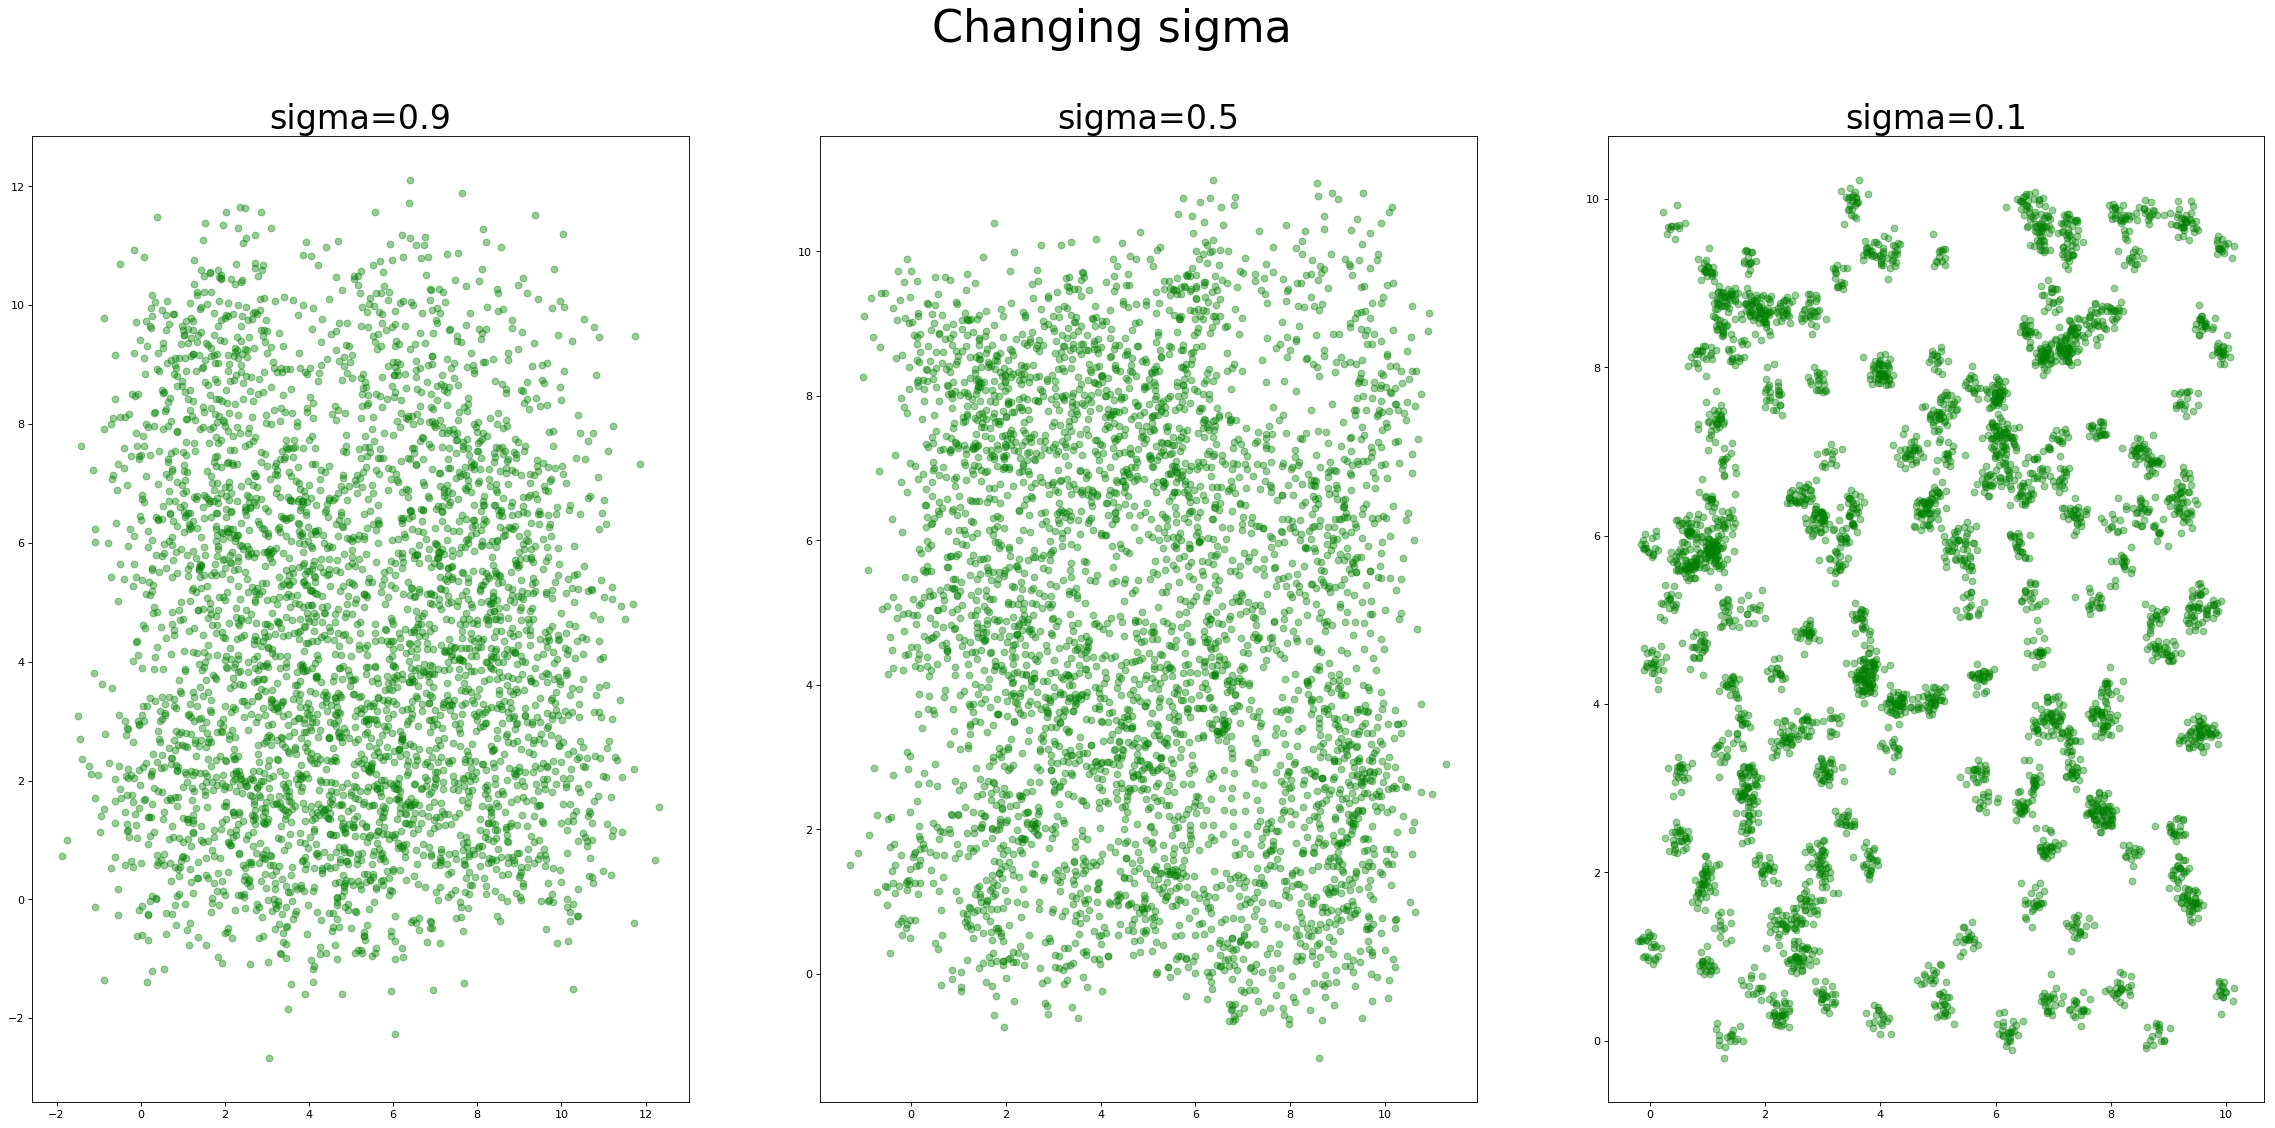

In [31]:
fig=plt.figure(figsize=(36, 16), dpi= 80, facecolor='w', edgecolor='k')
fig.suptitle("Changing sigma", fontsize=40)

plt.subplot(131)
plt.title("sigma=0.9", fontsize=30)
plt.scatter(b1[0],b1[1], c='g', alpha = 0.4) 
plt.subplot(132)
plt.title("sigma=0.5", fontsize=30)
plt.scatter(b2[0],b2[1], c='g', alpha = 0.4)
plt.subplot(133)
plt.title("sigma=0.1", fontsize=30)
plt.scatter(b3[0],b3[1], c='g', alpha = 0.4)

In [32]:
[len(b1[0]),
len(b2[0]),
len(b3[0])]

[3628, 3922, 4085]

Pretty obvious that lower sigma values create tighter clusters, with the same number of points.

We need our points to work with our mesa model grid. So points need to be rounded to the nearest whole numbers, and stay within our grid. The thomas process coded here gives off floating decimals and child points sometimes float off the edges of the grid. Also if we are going to round our coordinates to integers, we should get rid of redundant points. So an adapter function:

In [4]:
def makepos(rawpts, Dx=100):
    '''
    a function for getting the thomas points into 
    a useful format for mesa.
    '''
    ## round these floating decimal coords
    aa = [ int(round(i)) for i in rawpts[0] ]
    ## if too big, subtract:
    aatrim = [ i if i < Dx  else i-99 for i in aa ]
    bb = [ int(round(i)) for i in rawpts[1] ]
    ## if too big, subtract:
    bbtrim = [ i if i < Dx  else i-99 for i in bb ]
    ## make a set of unique tuples, for tree positions
    cc = list(set(list(zip(aatrim,bbtrim))))
    return(cc)

Try it out. Let's see what forcing our floating decimals generated by the poisson/thomas process into integers does to the point distribution:

In [18]:
aa = ThomasPP(kappa=0.01, sigma=1, mu=1, Dx=100)
bb = makepos(aa)
cc = list(zip(*bb))

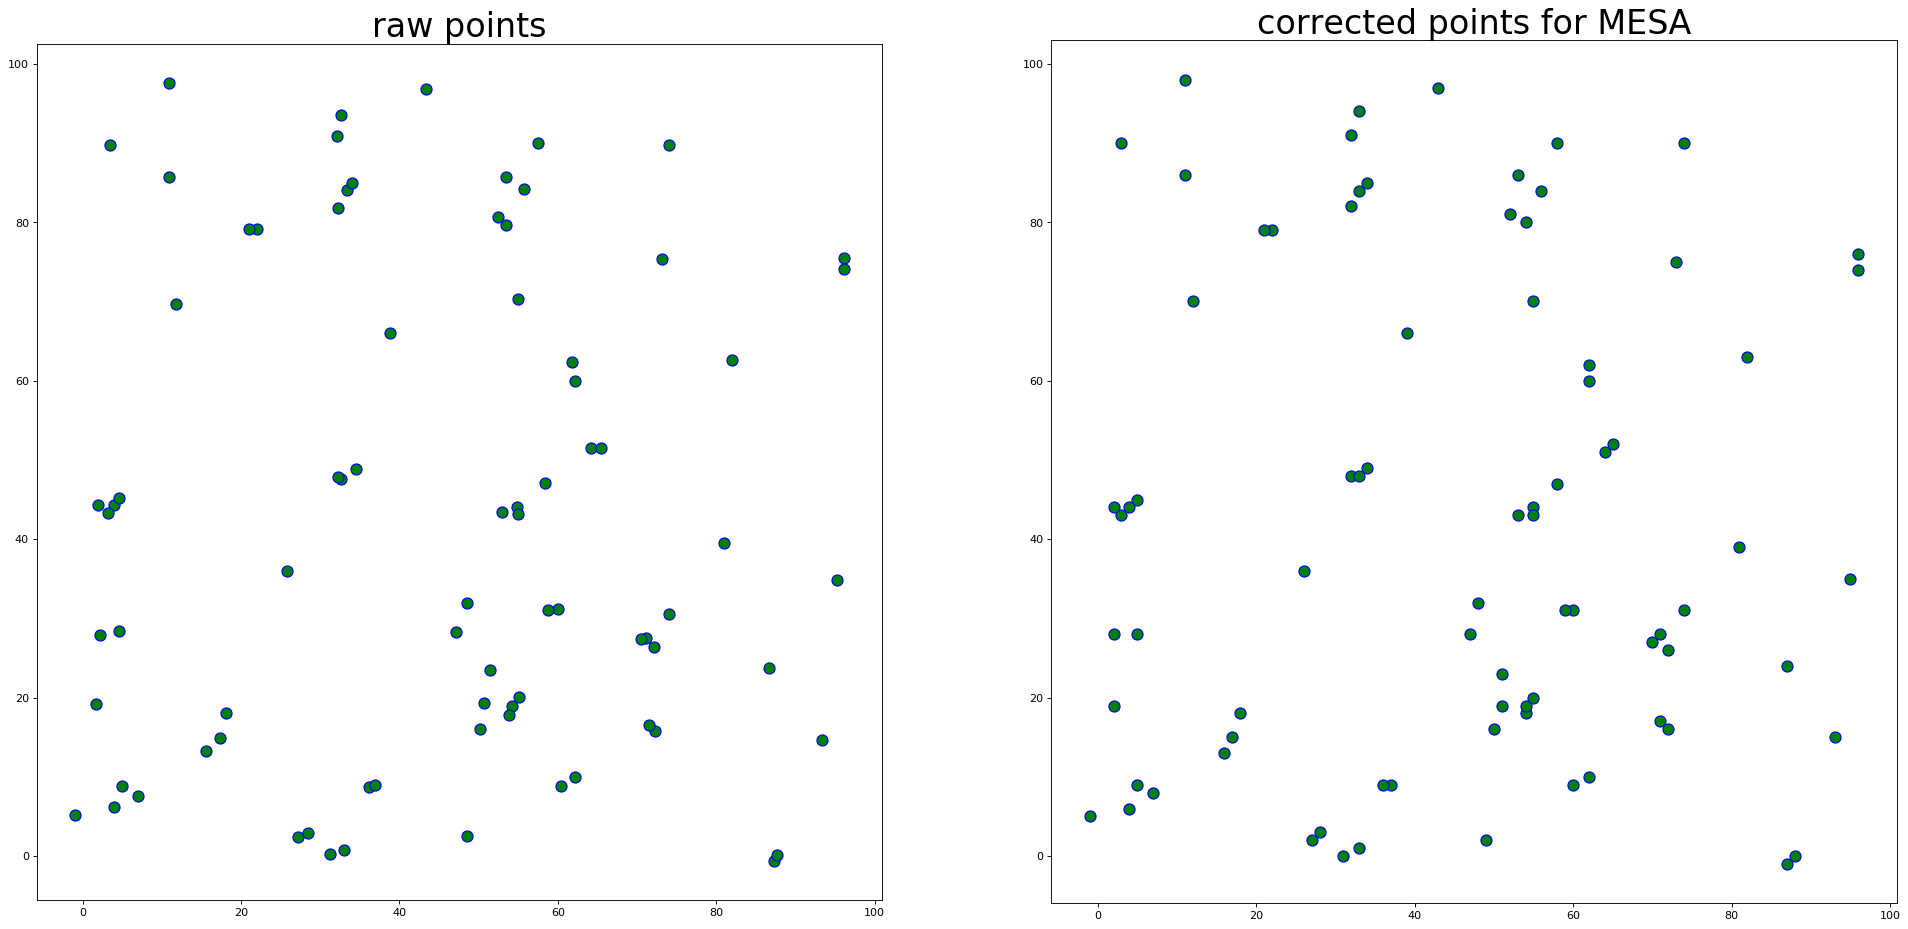

In [32]:
fig=plt.figure(figsize=(30, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121, aspect='equal' )
plt.title("raw points", fontsize=30)
plt.scatter( aa[0], aa[1], edgecolor='b', facecolor='none', alpha=1, s=100, c='g', )

plt.subplot(122, aspect='equal' )
plt.title("corrected points for MESA", fontsize=30)
plt.scatter( cc[0], cc[1], edgecolor='b', facecolor='none', alpha=1, s=100, c='g', )

Looks pretty good! Let's use this for the placement of trees in our agent-based model. We'll call it the [thomasprocess](https://github.com/danchurch/FA_ABM/blob/master/thomasprocess.py) module. 

[back to contents](#contents)

<a id='realforest'></a>
## Making a tropical forest

So how can we simulate the ecology of viaphytes in both an unlogged and fragmented forest. So what is a natural forest?

In the lowlands, [Hunter et al (2015)](#https://doi.org/10.1371/journal.pone.0132144) give examples of two sites of Amazonian rain forest with continuous canopy, and gaps (areas 10 m<sup>2</sup> or greater with canopy high 10m or lower) accounting for 2%-5% of total area. [Crowther et al (2015)](https://www.nature.com/nature/journal/v525/n7568/full/nature14967.html) give ~600 trees (stems > 10 cm DBH) per hectare as an average for tropical forests. That's a lot of trees. I can't find the numbers, but I assume that there are slightly fewer trees per hectare in tropical montane forests, but comparable numbers. What does it take to emulate this with our algorithms? 

In [53]:
aa = tp.ThomasPP(kappa=0.03, sigma=3, mu=2.2, Dx=100)
bb = tp.makepos(aa)
cc = list(zip(*bb))
len(cc[0])

590

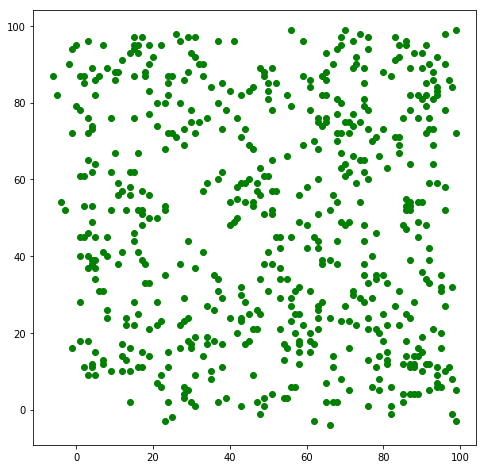

In [54]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.plot(cc[0],cc[1], 'go')


In [56]:
len(cc[0])

590

What's the average number of trees with this setting?:

In [3]:
forests=[]
for i in range(1000):
    aa = tp.ThomasPP(kappa=0.03, sigma=3, mu=2.2, Dx=100)
    bb = tp.makepos(aa)
    cc = list(zip(*bb))
    forests.append(len(cc[0]))

In [7]:
np.mean(forests)

633.92399999999998

In [4]:
np.mean(forests)

633.36800000000005

Seems reasonable. Having this many trees will make the model runs much more computationally expensive, though. Based on some previous experience, I'd say this many trees, all treat as individual agents as I have coded them, may bring a node on the computing cluster to it's knees. We'll see.

[back to contents](#contents)

<a id=deforest></a>
    
## Modeling deforestation

What does deforestation look like? Depends on the land use. I'll broadly categorize deforestation as either (1) fragmenting, where contiguous blocks of forest are removed, or (2) thinning, where trees are removed at <sup>+</sup>/<sub>-</sub> the same rate, through out the landscape, interspersed among leave trees. The first might generally to be the result of wholesale land use conversions - homesteading, conversion to agriculture, etc. The second would often be the result of selective logging ("highgrading"). 


Here we'll leave <sup>+</sup>/- the same number of trees on a plot, but with the two styles of deforestion, to highlight the very different forests that result.

A plotting function useful for both of the deforest methods is:

In [55]:
def plotcut(cutplotdata):
    ## accepts the dictionary output from fragup or selthin functions
    remcoords = [ i.pos for i in cutplotdata['remnants'] ] ## get all the coords
    rempts = list(zip(*remcoords)) ## unzip tuples into two tuples we can use for scatterplot
    ## also show the cut trees
    cutpos = { i.pos for i in cutplotdata['cuttrees'] } ## get all the coords
    cutpts = list(zip(*cutpos)) ## unzip tuples into two tuples we can use for scatterplot
    ## and the centers, just for reference:
    #if cutplotdata['centers']:
    #    fcepts = list(zip(*cutplotdata['centers'])) ## unzip tuples into two tuples we can use for scatterplot
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_ylim(0,100)
    ax.scatter( rempts[0], rempts[1], edgecolor='b', facecolor='none', alpha=1, s=100, c='g', )
    ## centers of fragments:
    #if cutplotdata['centers']:
    #    ax.scatter( fcepts[0], fcepts[1], edgecolor='red', facecolor='none', alpha=1, s=100, c='red', )
    ## cut trees:
    ax.scatter( cutpts[0], cutpts[1], edgecolor='b', facecolor='none', alpha=0.2, s=100, c='g', )


<a id='fragmentation'></a>
### Fragmentation of forest

I've included a method in our forest model to remove trees in either of the two ways mentioned. Fragmentation  style deforestation is controlled with two parameters, number and radius of fragment. 

In [51]:
losced = Forest()
aa=losced.fragup(15,10)

len(losced.getall(Tree))

240

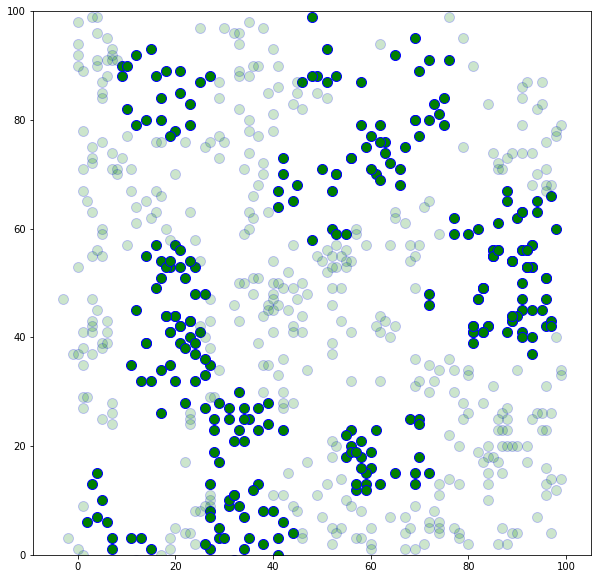

In [54]:
plotcut(aa)

We've left 15 fragments, with a radius of 10 m. The pale circles are the stumps of trees that were cut. 

<a id='thinning'></a>
### Thinning of forest

Thinning here means evenly dispersed harvest of trees over the landscape. The only parameter to vary is the intensity, given as a value between 0 and 1, where 1 is 100% removal of trees. 

In [38]:
losced = Forest()
aa=losced.selthin(.6)

In [39]:
len(losced.getall(Tree))

243

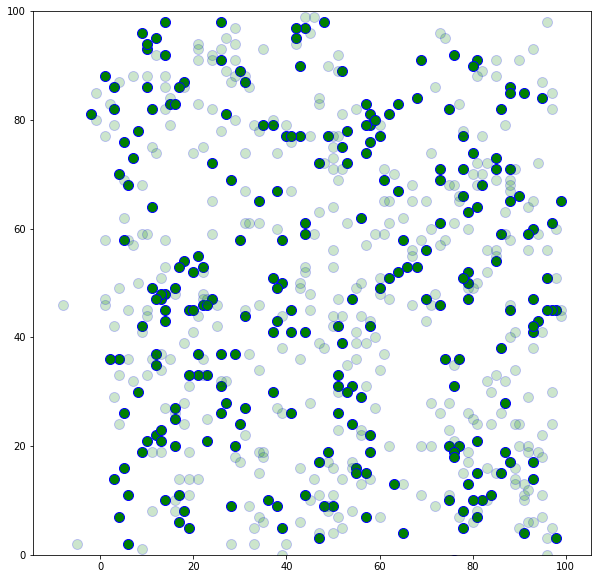

In [40]:
plotcut(aa)

This is a cut that left 40% of trees standing. If we want to make ecological comparisons between the two types of deforestation, we need to be able to make sure any differences we see aren't just the result of losing unequal amounts of trees. With thinning, it is easy to predict how many trees will remain after a harvest, if we know the intensity of the harvest. It's harder the percent of trees remaining after harvest to predict with the fragmentation model of deforestation, so let's plot a curve to use for this:

In [7]:
## a function to get ratio of trees before and after a fragmenting event:
def testf(centers,rad):
    leftover=[]
    for i in range(300):
        bb=Forest() ## build a forest
        before = len(bb.getall(Tree)) ## how many trees before cut?
        aa=bb.fragup(centers,rad) ## fragment
        after = len(bb.getall(Tree)) ## how many trees after cut?
        leftover.append(after/before) ## ratio of after/before
    return(np.mean(leftover))

## now do this 300 times per number fragments, hold frag size = 15m radius, 
## take the mean for each number of fragments from these 300 sims

radius15=[]
for i in range(40):
    imean=testf(i,15)
    radius15.append(imean)

pickle.dump(radius15, open('radius15.p', 'wb'))

## this is really computationally expensive. In the future, parallelize. 


Now look at our curve:

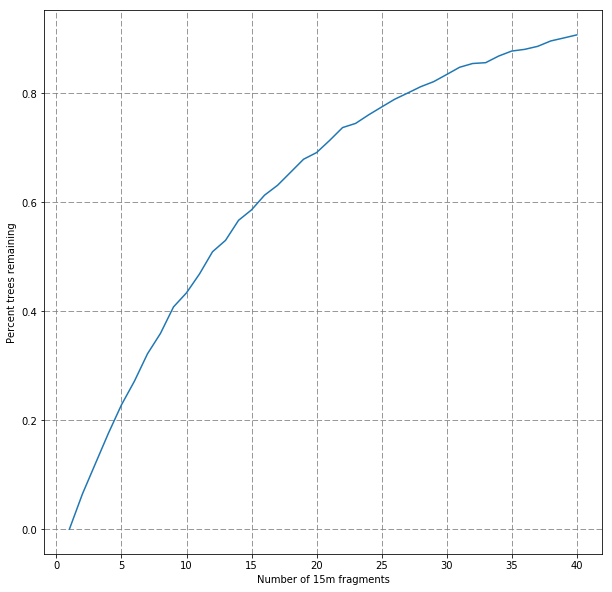

In [5]:
perloss = pickle.load(open('radius15.p', 'rb'))
x=list(range(1,41,1))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(x,perloss, '-')
ax.set_xlabel('Number of 15m fragments')
ax.set_ylabel('Percent trees remaining')
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')

So this can be used to make estimates of how many randomly-placed, 15m-radius forest fragments are need to retain a certain percentage of original forest cover of our 100m x 100m plot. For instance, 15 fragments should retain ~60% of the original trees. We can then compare the ecology of this forest to one that has been thinned evenly at an intensity of .4, or 40% removal. 

[back to contents](#contents)